In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

import IEFC_modules.iefc_simulation as iefc
from IEFC_modules import iefc_functions
reload(iefc)

import roman
import misc

wavelength_c = 575e-9*u.m

wavelength_ref = 0.5e-6*u.m
pixelscale_lamD_ref = 1/2
pixelscale_ref = 13e-6*u.m/u.pix
pixelscale_lamD = pixelscale_lamD_ref * (wavelength_ref/wavelength_c)
print(pixelscale_lamD)

wavelength = 575e-9*u.m
npsf = 64
psf_pixelscale = 13e-6*u.m/u.pix
# npsf = 256
# psf_pixelscale = 2.9587987694e-6*u.m/u.pix
psf_pixelscale_lamD = pixelscale_lamD * (psf_pixelscale/pixelscale_ref)
print(psf_pixelscale_lamD)

Nact = 48
dm_diam = 46.3*u.mm
act_spacing = 0.9906*u.mm


0.43478260869565216
0.43478260869565216


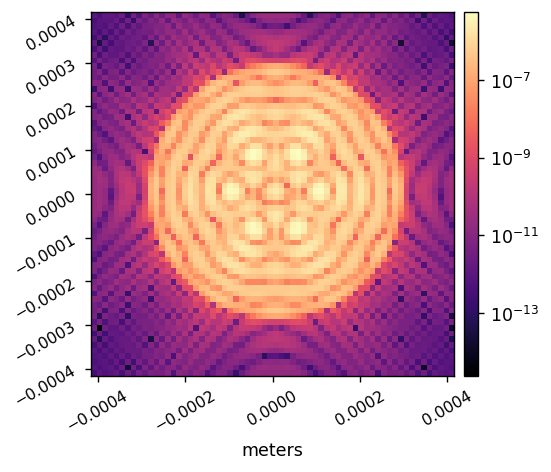

In [2]:
reload(roman)

hlci = roman.CGI(cgi_mode='hlc', use_fieldstop=True)
psf = hlci.calc_psf()

misc.myimshow(psf, lognorm=True, pxscl=hlci.psf_pixelscale)

# Create dark hole ROI to calibrate and control

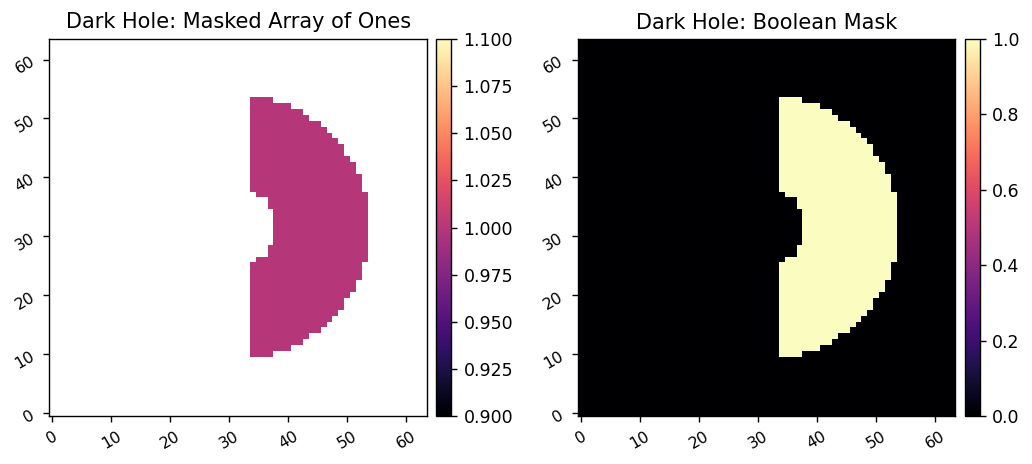

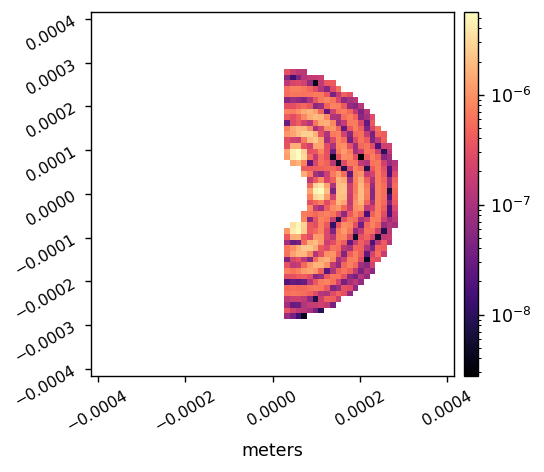

In [3]:
# set dark hole ROI (only annular dark-holes supported for now)
iwa = 2.8*psf_pixelscale/psf_pixelscale_lamD
owa = 9.7*psf_pixelscale/psf_pixelscale_lamD
roi_side = 'right'
roi_offset = 1*psf_pixelscale/psf_pixelscale_lamD

roi_mask = misc.create_annular_roi_mask(npsf, psf_pixelscale, iwa, owa, side=roi_side, offset=roi_offset)

misc.myimshow2(roi_mask, ~roi_mask.mask, 'Dark Hole: Masked Array of Ones', 'Dark Hole: Boolean Mask')
misc.myimshow(psf*roi_mask, lognorm=True, pxscl=hlci.psf_pixelscale)

# Create probe and fourier modes

Createing Fourier modes:  (64, 64)
(300, 2304) (2, 2304)


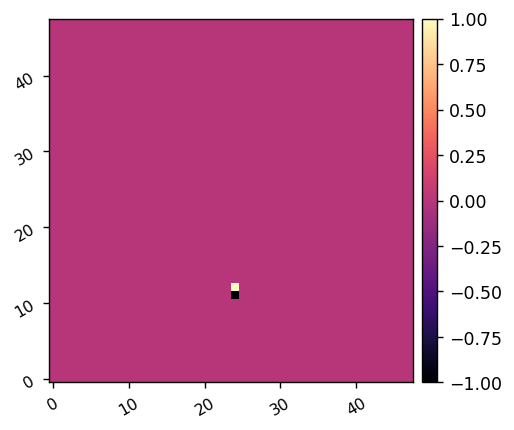

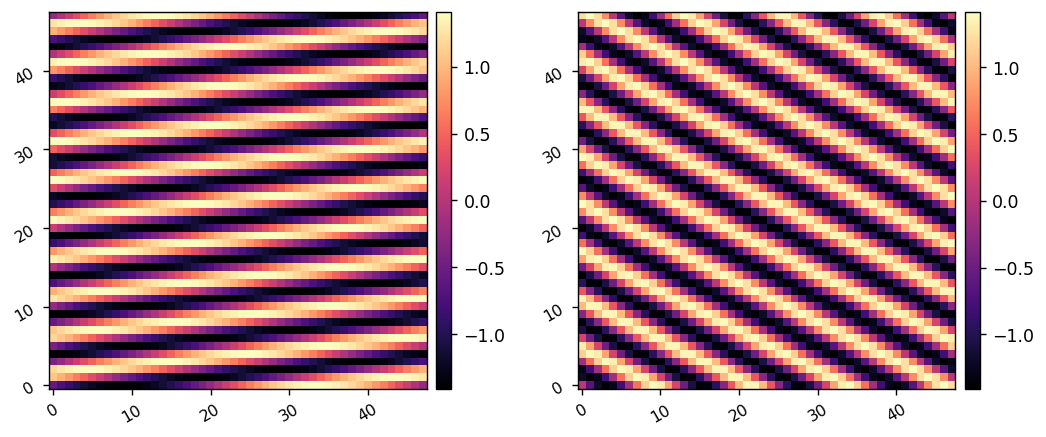

In [4]:
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

fourier_modes, fx, fy = iefc.create_fourier_modes(xfp, ~roi_mask.mask, Nact=Nact)
probe_modes = iefc.create_probe_poke_modes(Nact, Nact//2, Nact//4, Nact//2, Nact//4-1)

probe_amplitude = 0.05 * wavelength.to(u.m).value
calibration_amplitude = 0.006 * wavelength.to(u.m).value

print(fourier_modes.shape, probe_modes.shape)
misc.myimshow((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)))
misc.myimshow2(fourier_modes[0].reshape((Nact,Nact)), fourier_modes[140].reshape((Nact,Nact)))

# Calibrate IEFC

In [42]:
reload(iefc)
response_cube, calibration_cube = iefc.calibrate(hlci, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, fourier_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 300 in 53.753s
	Calibrated mode 2 / 300 in 107.290s
	Calibrated mode 3 / 300 in 160.428s
	Calibrated mode 4 / 300 in 213.685s
	Calibrated mode 5 / 300 in 267.244s
	Calibrated mode 6 / 300 in 320.639s
	Calibrated mode 7 / 300 in 373.828s
	Calibrated mode 8 / 300 in 427.484s
	Calibrated mode 9 / 300 in 480.785s
	Calibrated mode 10 / 300 in 533.974s
	Calibrated mode 11 / 300 in 587.550s
	Calibrated mode 12 / 300 in 640.991s
	Calibrated mode 13 / 300 in 694.253s
	Calibrated mode 14 / 300 in 747.446s
	Calibrated mode 15 / 300 in 801.154s
	Calibrated mode 16 / 300 in 854.497s
	Calibrated mode 17 / 300 in 907.747s
Calibration interrupted.
Calibration complete.


# Filter calibration data

In [ ]:
# Filter the calibration files by subtracting PCA modes
npca = 3
filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

# Create control matrix

In [ ]:
# Create the control matrix
relative_weight = 0.99
weights = dark_hole_mask * relative_weight + (1 - relative_weight) * full_mask

control_matrix = iefc.construct_control_matrix(filtered_response_cube, weights, rcond=3e-4, pca_modes=pca_modes)

# Run IEFC

In [ ]:
# The metric
metric_images = []
command = 0.0

## Run IEFC for num_iterations
num_iterations = 50
gain = -0.8
leakage = 0.0

In [ ]:
for i in range(num_iterations):
    print("Closed-loop iteration {:d} / {:d}".format(i+1, num_iterations))
#     delta_coefficients = iefc_functions.IEFC_single_iteration(tbi, probe_modes, probe_amplitude, 
#                                                               control_matrix, weights>0)
    delta_coefficients = iefc.single_iteration(hlci, probe_modes, probe_amplitude, control_matrix, weights>0)
    command = (1.0-leakage) * command + gain * delta_coefficients
    
    # Reconstruct the full phase from the Fourier modes
    voltage_command = np.einsum('ij, i->j', fourier_modes, command)
    
    # Set the current DM state
#     tbi.set_dm(voltage_command)
    hlci.set_dm1(dm_command)
#     ret = tbi.send_dm()
    
    # Take an image to estimate the metrics
    metric_images.append(hlci.snap())
    pass

# Testing

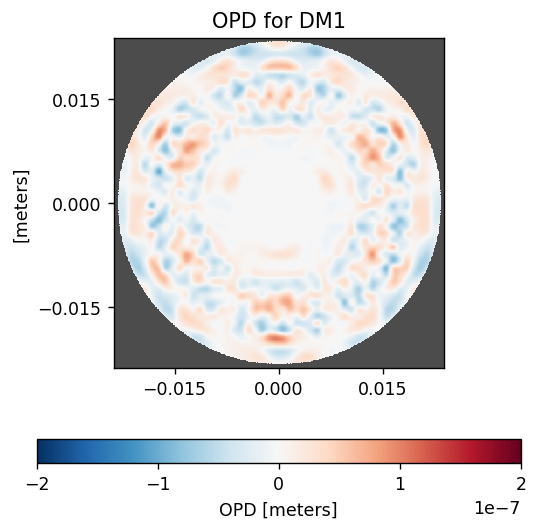

In [5]:
import poppy_roman_cgi_phasec as cgi
from poppy_roman_cgi_phasec import hlc
import poppy
reload(hlc)

dmdir = Path('/groups/douglase/kians-data-files/roman-cgi-phasec-data/dm-acts')

dm1_piston_fname = str(dmdir/'hlc_dm1.fits')
dm1_piston_map = fits.getdata(dm1_piston_fname)
dm2_piston_fname = str(dmdir/'hlc_dm2.fits')
dm2_piston_map = fits.getdata(dm2_piston_fname)

DM1 = poppy.ContinuousDeformableMirror(dm_shape=(Nact,Nact), name='DM1', actuator_spacing=act_spacing, radius=dm_diam/2,
                                       influence_func=str(dmdir/'proper_inf_func.fits'))
DM2 = poppy.ContinuousDeformableMirror(dm_shape=(Nact,Nact), name='DM2', actuator_spacing=act_spacing, radius=dm_diam/2,
                                       influence_func=str(dmdir/'proper_inf_func.fits'))

DM1.set_surface(dm1_piston_map)
DM2.set_surface(dm2_piston_map)

misc.display_dm(DM1)


In [ ]:

cgi_dir = Path('/groups/douglase/kians-data-files/roman-cgi-phasec-data')

psfs, wfs = hlc.run_multi(psf_pixelscale=psf_pixelscale, npsf=npsf, cgi_dir=cgi_dir, 
                                      dm1=[DM1, DM1], dm2=[DM2, DM2])